# Model Building and Evaluation

Adapted from Wafiq Syed 2020 [How to use Scikit-Learn Datasets for Machine Learning](https://towardsdatascience.com/how-to-use-scikit-learn-datasets-for-machine-learning-d6493b38eca3) and Dipanjan Sarkar et al. 2018. [Practical Machine Learning with Python](https://link.springer.com/book/10.1007/978-1-4842-3207-1).

## Overview

This tutorial covers core concepts in model building and evaluation, focusing on classification and clustering approaches using the Breast Cancer Wisconsin dataset. We'll explore various algorithms and metrics for evaluating their performance.

## Learning Objectives

- Learn to build and evaluate classification models using metrics like accuracy, precision, recall, and F1-score
- Understand how to interpret confusion matrices and ROC curves
- Apply clustering model evaluation using both external and internal validation methods
- Apply practical model evaluation techniques using scikit-learn's metrics module
- Gain hands-on experience with real biomedical data analysis

### Tasks to complete

- Build classification models
- Evaluate model performance using various metrics
- Create and analyze clustering models
- Generate performance visualizations
- Compare different evaluation approaches

## Prerequisites

- A working Python environment and familiarity with Python
- Basic understanding of machine learning concepts
- Familiarity with numpy and sklearn libraries
- Knowledge of basic statistical concepts


## Get Started

- Please select kernel "conda_tensorflow2_p310" from SageMaker notebook instance.


### Import libraries


In [32]:
# Import the warnings module to handle and control warning messages during code execution.
import warnings

# Import the pyplot module from matplotlib for creating plots and visualizations.
import matplotlib.pyplot as plt

# Import the numpy library for numerical computations, especially for handling arrays and matrices.
import numpy as np

# Import the pandas library for data manipulation and analysis, particularly using DataFrames.
import pandas as pd

# Import the interp function from numpy for interpolation, likely used in ROC curve calculations.
from numpy import interp

# Import dendrogram, fcluster, and linkage functions from scipy.cluster.hierarchy for hierarchical clustering and dendrogram plotting.
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

# Import datasets, linear_model, and metrics modules from sklearn for various machine learning tasks like loading datasets, linear models, and evaluation metrics.
from sklearn import datasets, linear_model, metrics

# Import the clone function from sklearn.base for creating copies of estimators.
#from sklearn.base import clone

# Import the KMeans class from sklearn.cluster for K-Means clustering algorithm.
from sklearn.cluster import KMeans

# Import the load_breast_cancer function from sklearn.datasets to load the breast cancer dataset.
from sklearn.datasets import load_breast_cancer

# Import the PCA class from sklearn.decomposition for Principal Component Analysis (dimensionality reduction).
from sklearn.decomposition import PCA

# Import necessary functions from scikit-learn's metrics module:
# - auc: Computes the Area Under the Curve (AUC) for a given Receiver Operating Characteristic (ROC) curve.
# - roc_curve: Computes the ROC curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds.
# - confusion_matrix: Computes a confusion matrix to evaluate the accuracy of a classification model.
from sklearn.metrics import auc, roc_curve, confusion_matrix

# Import the train_test_split function from sklearn.model_selection to split datasets into training and testing sets.
from sklearn.model_selection import train_test_split

# Import the KNeighborsClassifier class from sklearn.neighbors for K-Nearest Neighbors classification algorithm.
from sklearn.neighbors import KNeighborsClassifier

# Import LabelEncoder and label_binarize from sklearn.preprocessing for encoding categorical labels and binarizing labels in a one-vs-all fashion.
from sklearn.preprocessing import LabelEncoder, label_binarize

# Sets the backend of matplotlib to the 'inline' backend: With this backend,
# the output of plotting commands is displayed inline within frontends like
# the Jupyter notebook, directly below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.
%matplotlib inline

## Breast Cancer Classification
This demonstration uses the Breast Cancer Wisconsin (Diagnostic) Dataset to develop a binary classification model. After importing the dataset—which includes features computed from digitized breast mass images—we will:
- Explore the data structure, examining key attributes like radius, texture, and concavity of cell nuclei
- Preprocess the data to handle missing values (if any) and normalize feature scales
- Train a baseline classifier (e.g., logistic regression or random forest) to distinguish malignant (cancerous) from benign (non-cancerous) cases
- Evaluate performance using metrics like accuracy, precision, and recall to assess clinical relevance

The workflow highlights fundamental ML practices while addressing a real-world medical diagnostic challenge.

### Import “Breast Cancer Wisconsin” dataaset

The datasets are available in *sklearn.datasets*, with each dataset accessible through standardized loader functions following the naming convention *load_DATASET()*, where DATASET corresponds to the specific dataset name. For example, the Boston housing dataset can be loaded using load_boston(), while the iris dataset is loaded via load_iris(). These functions provide a consistent interface for retrieving both the feature data and corresponding target labels, making it straightforward to import benchmark datasets for machine learning tasks. The loaded datasets typically return dictionary-like objects containing the data matrix, target values, and metadata such as feature names and descriptions.

In [33]:
# Loads the breast cancer dataset from scikit-learn's datasets module.
bc = datasets.load_breast_cancer()

Scikit-Learn's dataset loading functions (e.g., `load_breast_cancer()`) return data as a `Bunch` object - essentially a dictionary-like container with additional attribute access capabilities. This specialized object stores both the dataset and its metadata in key-value pairs. To examine its structure, we can inspect the available keys which typically include:

- `data`: The feature matrix (n_samples × n_features)
- `target`: The label array
- `feature_names`: Descriptive column headers
- `target_names`: Class label meanings
- `DESCR`: Full dataset documentation

This organization allows both dictionary-style access (`bunch['data']`) and object-style access (`bunch.data`), combining the flexibility of dictionaries with the convenience of attribute notation.

In [34]:
# Prints the keys of the 'bc' dictionary.
print(bc.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])



Scikit-Learn datasets follow a consistent structure with these key components:
- The `data` key contains the feature matrix as a NumPy array, comprising tumor characteristics like radius and area that help distinguish malignant vs. benign cases.
- Corresponding feature names are available in `feature_names`.
- The `target` key holds the prediction labels (0 for malignant, 1 for benign) as another NumPy array, with category names in `target_names`.
- Additional metadata includes: `DESCR` for detailed dataset descriptions,
- `filename` showing the source CSV path,
- and `data_module` indicating the originating Python module. 

This standardized structure separates predictive features (`data`) from outcomes (`target`), enabling clean model development. In our tumor classification task, the binary target variable uses 0/1 encoding for malignant/benign classification respectively, while the feature matrix contains all measurable tumor attributes that may predict this status.

Before proceeding with analysis, let's examine the key characteristics of our dataset.

In [35]:
# Prints the description of the dataset object 'bc' to the console.
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

### Working with the Dataset

The _pandas_ library provides essential tools for comprehensive dataset exploration.

In [36]:
# Read the DataFrame using pandas, initializing it with breast cancer feature data and column names from bc.feature_names
df = pd.DataFrame(bc.data, columns=bc.feature_names)

# Add a new column named "target" to the DataFrame
df["target"] = bc.target

# Display the first five rows of the DataFrame to show the initial data structure
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


We can run the code below to see the value of this dataset


In [37]:
# Displays a concise summary of the DataFrame 'df', including column names, data types, non-null values, and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

The dataset exhibits two particularly valuable characteristics for machine learning:  

1. **Complete Data Integrity**: All 569 entries are fully populated across every column, eliminating the need for missing value imputation or row elimination. This comprehensive data coverage saves significant preprocessing time.  

2. **Numerical Uniformity**: Every feature is encoded numerically, which is critical as Scikit-Learn's algorithms require numerical input. While real-world datasets often contain categorical variables requiring transformation (e.g., one-hot encoding), these curated datasets are preprocessed to meet Scikit-Learn's requirements.  

These qualities make Scikit-Learn's datasets exceptionally useful for learning machine learning concepts without getting bogged down in data cleaning tasks. The library's attention to data readiness allows practitioners to focus on model development and evaluation—a significant advantage for educational purposes and prototyping.

### Hands-On AI: Tumor Classification Model

Let's develop a machine learning model to distinguish between malignant (cancerous/spreading) and benign (non-cancerous) tumors. This practical demonstration will:

1. Illustrate fundamental ML workflow using real biomedical data  
2. Implement a **K-Nearest Neighbors (KNN)** classifier as our baseline model  
3. Provide a template you can adapt for your own predictive modeling projects  

The exercise covers essential steps:  
- Data preparation for binary classification  
- Feature-target separation  
- Model training and evaluation  
- Interpretation of diagnostic metrics  

**Why KNN?** Its simplicity makes it ideal for educational purposes while still achieving clinically relevant performance on tumor classification tasks.

First, we split the dataset into two parts: one for training the model and the other for testing it. The training set provides the model with data to learn patterns and relationships, while the testing set allows us to evaluate how well the model performs on unseen data

In [38]:
# Store the feature data from the 'bc' dataset into the variable 'X'.
X = bc.data

# Store the target data (labels) from the 'bc' dataset into the variable 'y'.
y = bc.target

# Split the feature data (X) and target data (y) into training and testing sets using the train_test_split function.
# X: Features (independent variables)
# y: Target (dependent variable)
# test_size=0.3: 30% of the data will be used for testing, and 70% for training
# random_state=42: Ensures reproducibility by fixing the random seed for the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Next, we will train the model.

In [39]:
# Classifier implementing the k-nearest neighbors vote. Initializes a KNeighborsClassifier object with 6 neighbors.
logreg = KNeighborsClassifier(n_neighbors=6)

# Fit the k-nearest neighbors classifier from the training dataset. 
# Trains the KNeighborsClassifier model using the training features (X_train) and training labels (y_train).
logreg.fit(X_train, y_train)

# Return the mean accuracy on the given test data and labels. 
# Calculates and prints the accuracy score of the trained KNeighborsClassifier model on the test features (X_test) and test labels (y_test).
print("Model accurcy: ", logreg.score(X_test, y_test))

Model accurcy:  0.9590643274853801


The `n_neighbors` parameter in KNN determines the number of neighboring data points considered when making a classification decision. Choosing this value involves a trade-off:

- **Smaller values**: Result in more intricate decision boundaries that closely fit the training data but may lead to overfitting and increased sensitivity to noise.
- **Larger values**: Produce smoother decision boundaries that enhance generalization but risk overlooking important patterns in the data.

Selecting an appropriate `n_neighbors` value requires balancing these factors to capture local patterns without excessive noise influence. This choice should be guided by the dataset's characteristics (e.g., larger datasets or datasets with more noise often benefit from larger values of `n_neighbors`) and your domain knowledge. Additionally, cross-validation is commonly used to test different values and identify the optimal setting for a given dataset.

For the Breast Cancer Wisconsin dataset, a value of 6 was chosen based on prior experimentation showing good performance with this dataset, the relatively small size of the dataset, and the desire to balance capturing local patterns while still avoiding noise.


## Clustering Example

In this example, we will explore how to fit a clustering model using the "Breast Cancer Wisconsin" dataset. Although clustering is typically an unsupervised learning technique, we will use a labeled dataset in this case to evaluate the clustering results by comparing them with the actual labels. It’s important to note that in real-world scenarios, labeled data is often unavailable, which is why unsupervised methods like clustering are commonly used. To provide a comprehensive understanding, we will demonstrate two different clustering algorithms: one from **partitioning-based clustering** (e.g., K-Means) and one from **hierarchical clustering** (e.g., Agglomerative Clustering). This will allow us to compare the approaches and understand their strengths and limitations.


In [40]:
# Load the Wisconsin Breast Cancer dataset into the variable 'bc'.
bc = load_breast_cancer()

# Store the feature data
# Assign the feature data from the loaded dataset 'bc' to the variable 'X'.
X = bc.data

# store the target data
# Assign the target data (labels) from the loaded dataset 'bc' to the variable 'y'.
y = bc.target

# Print the shape of the feature data 'X' and the names of the features from 'bc.feature_names'.
print(X.shape, bc.feature_names)

(569, 30) ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


It is evident that the dataset consists of 569 observations, each described by 30 attributes or features.

### Partition-Based Clustering Example

In this section, we will use the **K-means** algorithm, one of the simplest and most popular partition-based clustering methods, as our example. K-means is a centroid-based clustering algorithm that works as follows:

1. **Initialization**:
   - The algorithm starts by assuming a predefined number of clusters (`k`) in the data.
   - Initial cluster centers are randomly assigned.

2. **Assignment**:
   - Each data point is assigned to the nearest cluster center using the **Euclidean distance** as the distance metric.

3. **Update**:
   - After assigning all data points, the algorithm recalculates the center (centroid) of each cluster as the mean of all points assigned to that cluster.

4. **Iteration**:
   - The assignment and update steps are repeated iteratively until the cluster centers no longer change significantly, indicating convergence.

5. **Stopping Condition**:
   - The algorithm stops when the reassignment of data points no longer changes the cluster centers.

#### Variants of K-means:
- **K-medoids**: A robust alternative to K-means that uses actual data points (medoids) as cluster centers instead of centroids, making it less sensitive to outliers.

#### Key Characteristics:
- K-means is efficient and works well for large datasets.
- It requires the number of clusters (`k`) to be specified in advance.
- The algorithm is sensitive to the initial placement of cluster centers, which can lead to suboptimal results.

In [41]:
# Initialize KMeans clustering object, specifying the number of clusters and random state.
km = KMeans(n_clusters=2, random_state=2)

# Fit the K-means model to the data X, which performs the clustering.
km.fit(X)

# Get the cluster labels assigned to each data point by the fitted K-means model.
labels = km.labels_

# Get the coordinates of the cluster centers calculated by K-means.
centers = km.cluster_centers_

# Print the cluster labels for the first 10 data points to see cluster assignments.
print(labels[:10])

# Print the cluster centers, representing the mean feature vector for each cluster.
# These centers are numerical values in the feature space (30 dimensions in this case) and indicate the central point of each cluster.
print(centers)

[1 1 1 0 1 0 1 0 0 0]
[[1.25562991e+01 1.85703653e+01 8.11234703e+01 4.96061872e+02
  9.48844977e-02 9.10998174e-02 6.24377642e-02 3.34325434e-02
  1.78057991e-01 6.34540183e-02 3.04190868e-01 1.21515320e+00
  2.15288059e+00 2.37852922e+01 7.17326256e-03 2.34746895e-02
  2.87455128e-02 1.06363242e-02 2.06135799e-02 3.74750297e-03
  1.40439018e+01 2.47095434e+01 9.19375114e+01 6.19647945e+02
  1.29959110e-01 2.23311758e-01 2.19214947e-01 9.13298425e-02
  2.83553653e-01 8.32819406e-02]
 [1.93799237e+01 2.16945802e+01 1.28231298e+02 1.18592977e+03
  1.01294580e-01 1.48612977e-01 1.76939466e-01 1.00698779e-01
  1.91539695e-01 6.06029008e-02 7.42803817e-01 1.22253817e+00
  5.25058015e+00 9.56781679e+01 6.59868702e-03 3.21766947e-02
  4.24197710e-02 1.56739847e-02 2.03039695e-02 3.95338931e-03
  2.37094656e+01 2.89126718e+01 1.58496183e+02 1.75302290e+03
  1.40424733e-01 3.57757710e-01 4.49306107e-01 1.92431069e-01
  3.11881679e-01 8.61654962e-02]]


In [42]:
# We will leverage PCA to reduce the input dimensions (30) to two principal components
# and visualize the clusters on top of the same.

# Instantiate PCA object from scikit-learn, specifying that we want to reduce the data to 2 principal components.
pca = PCA(n_components=2)

# Fit PCA to the data X and then transform X to its first 2 principal components, storing the result in bc_pca.
bc_pca = pca.fit_transform(X)

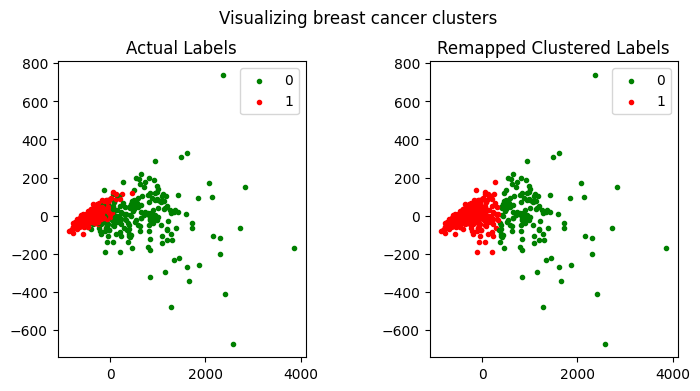

In [43]:
# Create a mapping between clustered labels and actual labels
def remap_labels(y_true, y_pred):
    # Create a confusion matrix to compare actual labels (y_true) and clustered labels (y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    
    # Find the mapping that maximizes alignment between clustered and actual labels
    # Create a mapping dictionary to align clustered labels with actual labels
    mapping = {}

    # Iterate over each clustered label (columns of the confusion matrix)
    for clustered_label in range(confusion.shape[1]):
        # Find the actual label (row index) that corresponds to the majority of the current clustered label
        # np.argmax returns the index of the maximum value in the column, which represents the actual label
        actual_label = np.argmax(confusion[:, clustered_label])
        
        # Map the clustered label to the corresponding actual label
        mapping[clustered_label] = actual_label
    
    # Remap the clustered labels using the mapping dictionary
    # - y_pred: The original clustered labels (e.g., output from a clustering algorithm like K-means)
    # - mapping: A dictionary that maps clustered labels to actual labels
    remapped_labels = np.array([mapping[label] for label in y_pred])
    
    return remapped_labels

# Remap the clustered labels to align with actual labels
remapped_labels = remap_labels(y, labels)

# Visualize the clusters on the reduced 2D feature space for the actual labels as well as the remapped clustered labels.

# Create a figure and a set of subplots:
# - 1 row, 2 columns (side-by-side plots)
# - figsize=(8, 4): Set the figure size to 8 inches wide and 4 inches tall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Set a super title for the entire figure:
# - "Visualizing breast cancer clusters": The main title describing the purpose of the visualization
fig.suptitle("Visualizing breast cancer clusters")

# Adjust the spacing of the subplots:
# - top=0.85: Add space at the top of the figure to prevent the super title from overlapping with the subplot titles
# - wspace=0.5: Add horizontal space (width space) between the two subplots to avoid overlap
fig.subplots_adjust(top=0.85, wspace=0.5)

# Plot actual labels in the first subplot (ax1)
ax1.set_title("Actual Labels")  # Set the title of the first subplot to "Actual Labels"

# Iterate over each data point using its index 'i'
for i in range(len(y)):
    # If the actual label 'y[i]' is 0, plot the point in green
    if y[i] == 0:
        c1 = ax1.scatter(bc_pca[i, 0], bc_pca[i, 1], c="g", marker=".")
    # If the actual label 'y[i]' is 1, plot the point in red
    if y[i] == 1:
        c2 = ax1.scatter(bc_pca[i, 0], bc_pca[i, 1], c="r", marker=".")

# Plot remapped clustered labels in the second subplot (ax2)
ax2.set_title("Remapped Clustered Labels")  # Set the title of the second subplot to "Remapped Clustered Labels"

# Iterate over each data point using its index 'i'
for i in range(len(remapped_labels)):
    # If the remapped clustered label 'remapped_labels[i]' is 0, plot the point in green
    if remapped_labels[i] == 0:
        c3 = ax2.scatter(bc_pca[i, 0], bc_pca[i, 1], c="g", marker=".")
    # If the remapped clustered label 'remapped_labels[i]' is 1, plot the point in red
    if remapped_labels[i] == 1:
        c4 = ax2.scatter(bc_pca[i, 0], bc_pca[i, 1], c="r", marker=".")

# Add legends to the subplots
# - l1: Legend for the first subplot (ax1), using handles 'c1' and 'c2' and labels "0" and "1"
l1 = ax1.legend([c1, c2], ["0", "1"])
# - l2: Legend for the second subplot (ax2), using handles 'c3' and 'c4' and labels "0" and "1"
l2 = ax2.legend([c3, c4], ["0", "1"])

# Display the figure with both subplots
plt.show()

On the left, the plot titled "Actual Labels" represents the true class labels for breast cancer data. The green points correspond to one class (labeled as 0), and the red points represent the other class (labeled as 1). The data distribution shows that the two classes are somewhat separable, with red points clustered more tightly in one region and green points spread out.

On the right, the plot titled "Remapped Clustered Labels" shows the labels assigned by an unsupervised clustering algorithm, in this case, K-Means. Since clustering methods do not inherently preserve original labels, the assigned clusters might have different numerical labels, which have been remapped to match the original classification.

The goal of this visualization is to compare how well the clustering algorithm's predictions align with the actual labels. The clustering results appear to broadly capture the actual distribution of classes, as the general separation pattern remains similar. However, there may be some misclassified points where the clustering model fails to perfectly match the ground truth.

This kind of comparison helps assess the effectiveness of clustering in capturing inherent patterns in the dataset without supervision.

### Hierarchical Clustering Example

In this section, we will use the same dataset to perform **hierarchical clustering** and compare the results with those obtained from **K-means clustering** and the **actual labels**. Hierarchical clustering is a powerful clustering technique that builds a hierarchy of clusters, either through a bottom-up (agglomerative) or top-down (divisive) approach.

#### Agglomerative Clustering
Agglomerative clustering is a type of hierarchical clustering that uses a **bottom-up approach**:
- **Initialization**: Each observation starts in its own cluster.
- **Merging**: Clusters are successively merged based on a chosen **linkage criterion**.
- **Stopping Condition**: The process continues until all observations are merged into a single cluster or a predefined number of clusters is reached.

#### Linkage Criteria
The choice of linkage criterion determines how the distance between clusters is calculated, influencing the merge strategy. Common linkage criteria include:
- **Ward**: Minimizes the variance of the clusters being merged.
- **Complete Linkage**: Uses the maximum distance between observations in two clusters.
- **Average Linkage**: Uses the average distance between all pairs of observations in two clusters.
- **Single Linkage**: Uses the minimum distance between observations in two clusters.

In [44]:
# Compute the linkage matrix using Ward’s minimum variance criterion.
# Perform hierarchical/agglomerative clustering.
# Returns hierarchical clustering encoded as a linkage matrix.
# Apply hierarchical clustering to the data 'X' using Ward's minimum variance method.
Z = linkage(X, "ward")

# Print the resulting linkage matrix 'Z' to the console.
print(Z)

[[2.87000000e+02 3.36000000e+02 3.81596727e+00 2.00000000e+00]
 [1.06000000e+02 4.20000000e+02 4.11664267e+00 2.00000000e+00]
 [5.50000000e+01 2.51000000e+02 4.93361024e+00 2.00000000e+00]
 ...
 [1.13000000e+03 1.13200000e+03 6.19607483e+03 8.60000000e+01]
 [1.13100000e+03 1.13300000e+03 8.36899225e+03 4.83000000e+02]
 [1.13400000e+03 1.13500000e+03 1.83711029e+04 5.69000000e+02]]


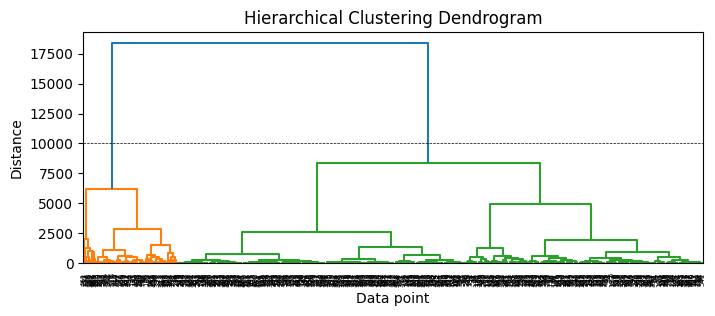

In [45]:
# Use a dendrogram to visualize the hierarchical clustering distance-based merges.
# Create a new figure for the dendrogram plot with a specified size (width=8 inches, height=3 inches).
plt.figure(figsize=(8, 3))

# Set the title of the dendrogram plot.
plt.title("Hierarchical Clustering Dendrogram")

# Set the label for the x-axis, representing the data points.
plt.xlabel("Data point")

# Set the label for the y-axis, representing the distance between clusters.
plt.ylabel("Distance")

# Plot the hierarchical clustering as a dendrogram using the linkage matrix 'Z'.
dendrogram(Z)

# Add a horizontal line to the dendrogram to help in visually determining a cutoff for cluster formation.
# y: position of the horizontal line on the y-axis (distance), set to 10000 in data coordinates.
# c: color of the line, set to 'k' for black.
# ls: line style, set to '--' for dashed line.
# lw: line weight, set to 0.5 for a thin line.
plt.axhline(y=10000, c="k", ls="--", lw=0.5)

# Display the dendrogram plot.
plt.show()

In [46]:
# Get the cluster labels from hierarchical clustering.
# Define a threshold distance 'max_dist' and set it to 10000. 
# This value will be used as the maximum distance to form clusters.
max_dist = 10000  

# Form flat clusters from the hierarchical clustering defined by the given linkage matrix. 
# Here the 'fcluster' function is used to generate flat clusters from a pre-computed hierarchical clustering.
#   - Z: This parameter is expected to be the linkage matrix, which is the output of hierarchical clustering algorithms like 'linkage' in scipy. It encodes the hierarchical relationships between data points.
#   - max_dist: This parameter specifies the threshold distance for forming clusters. Clusters will be formed such that the maximum cophenetic distance between any two original observations in the same cluster is no more than 'max_dist'.
#   - criterion="distance": This parameter defines the criterion to use for forming flat clusters. Here, "distance" means that clusters are formed based on the 'max_dist' distance threshold.
# The resulting flat cluster labels are assigned to the variable 'hc_labels'. Each data point will be assigned a cluster label based on the distance criterion.
hc_labels = fcluster(
    Z, max_dist, criterion="distance"
)

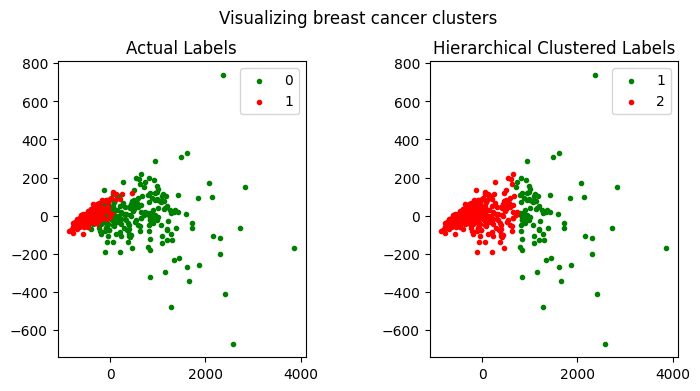

In [47]:
# This code block aims to visualize and compare cluster outputs based on PCA-reduced dimensions 
# against the original label distribution of a breast cancer dataset.

# Create a figure and a set of subplots (1 row, 2 columns) for visualization, setting the figure size to 8x4 inches.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Set the main title for the entire figure, which encompasses both subplots.
fig.suptitle("Visualizing breast cancer clusters")

# Adjust subplot parameters to provide more space at the top for the suptitle and adjust horizontal spacing between subplots.
fig.subplots_adjust(top=0.85, wspace=0.5)

# Set the title for the first subplot (ax1) to "Actual Labels", representing the ground truth.
ax1.set_title("Actual Labels")

# Set the title for the second subplot (ax2) to "Hierarchical Clustered Labels", showing the clusters found by hierarchical clustering.
ax2.set_title("Hierarchical Clustered Labels")

# Iterate through each data point in the dataset using an index 'i' ranging from 0 to the length of 'y' (actual labels).
for i in range(len(y)):
    # Check if the actual label 'y[i]' for the i-th data point is 0.
    if y[i] == 0:
        # If the label is 0, create a scatter plot point on the first subplot (ax1) using the PCA-reduced data 'bc_pca[i, 0]' (first principal component) and 'bc_pca[i, 1]' (second principal component).
        # Set the color of the point to green ('g') and the marker style to a dot ('.'). Assign the scatter plot object to 'c1'.
        c1 = ax1.scatter(bc_pca[i, 0], bc_pca[i, 1], c="g", marker=".")
    
    # Check if the actual label 'y[i]' for the i-th data point is 1.
    if y[i] == 1:
        # If the label is 1, create a scatter plot point on the first subplot (ax1) using the PCA-reduced data 'bc_pca[i, 0]' and 'bc_pca[i, 1]'.
        # Set the color of the point to red ('r') and the marker style to a dot ('.'). Assign the scatter plot object to 'c2'.
        c2 = ax1.scatter(bc_pca[i, 0], bc_pca[i, 1], c="r", marker=".")

    # Check if the hierarchical clustering label 'hc_labels[i]' for the i-th data point is 1.
    if hc_labels[i] == 1:
        # If the cluster label is 1, create a scatter plot point on the second subplot (ax2) using the PCA-reduced data 'bc_pca[i, 0]' and 'bc_pca[i, 1]'.
        # Set the color of the point to green ('g') and the marker style to a dot ('.'). Assign the scatter plot object to 'c3'.
        c3 = ax2.scatter(bc_pca[i, 0], bc_pca[i, 1], c="g", marker=".")
    
    # Check if the hierarchical clustering label 'hc_labels[i]' for the i-th data point is 2.
    if hc_labels[i] == 2:
        # If the cluster label is 2, create a scatter plot point on the second subplot (ax2) using the PCA-reduced data 'bc_pca[i, 0]' and 'bc_pca[i, 1]'.
        # Set the color of the point to red ('r') and the marker style to a dot ('.'). Assign the scatter plot object to 'c4'.
        c4 = ax2.scatter(bc_pca[i, 0], bc_pca[i, 1], c="r", marker=".")

# Create a legend for the first subplot (ax1) using the scatter plot objects 'c1' and 'c2', labeling them as "0" and "1" respectively, and assign the legend object to 'l1'.
l1 = ax1.legend([c1, c2], ["0", "1"])

# Create a legend for the second subplot (ax2) using the scatter plot objects 'c3' and 'c4', labeling them as "1" and "2" respectively, and assign the legend object to 'l2'.
l2 = ax2.legend([c3, c4], ["1", "2"])

We observe two distinct clusters, although there is noticeably more overlap between them compared to the K-means method, resulting in a higher number of mislabeled instances. It's important to note the cluster label values—1 and 2 in this case—are arbitrary and serve only to differentiate the clusters; they carry no intrinsic meaning. A key advantage of this method is that it does not require specifying the number of clusters in advance, as the model determines the optimal number based on the underlying data.

## Classification Model Evaluation Metrics


In [48]:
# Let's first prepare train and test datasets to build our classification models.
# Split the feature matrix X and target vector y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    # X is the feature matrix containing the independent variables.
    X,
    # y is the target vector containing the dependent variable (labels).
    y,
    # test_size=0.3 specifies that 30% of the data will be used for testing, and 70% for training.
    test_size=0.3,
    # random_state=42 ensures that the data split is reproducible. Using the same random_state will result in the same split each time the code is run.
    random_state=42,
)

# Print the shapes of the training and testing feature matrices to verify the split.
print(X_train.shape, X_test.shape)

(398, 30) (171, 30)


In [49]:
# Filter all warnings to be ignored to suppress them from output.
warnings.filterwarnings("ignore")

# Initialize a Logistic Regression model from scikit-learn's linear_model module.
logistic = linear_model.LogisticRegression()

# Train the Logistic Regression model using the training data (X_train features and y_train labels).
logistic.fit(X_train, y_train)

LogisticRegression()

### Confusion Matrix


In [50]:
# Define a function to display a formatted confusion matrix.
def display_confusion_matrix(true_labels, predicted_labels, classes=[1, 0]):
    # Determine the total number of classes from the input 'classes' list.
    total_classes = len(classes)
    
    # Define levels and codes for creating a MultiIndex for pandas DataFrame columns and rows.
    level_labels = [total_classes * [0], list(range(total_classes))]
    
    # Calculate the confusion matrix using scikit-learn's metrics.confusion_matrix function.
    cm = metrics.confusion_matrix(
        # Pass the true labels to the confusion_matrix function.
        y_true=true_labels,
        # Pass the predicted labels to the confusion_matrix function.
        y_pred=predicted_labels,
        # Specify the classes to be considered in the confusion matrix.
        labels=classes,
    )
    # Create a pandas DataFrame to present the confusion matrix in a structured format.
    cm_frame = pd.DataFrame(
        # Use the calculated confusion matrix 'cm' as the data for the DataFrame.
        data=cm,
        # Define the columns of the DataFrame using pandas MultiIndex for hierarchical column labels ('Predicted:' and class names).
        columns=pd.MultiIndex(levels=[["Predicted:"], classes], codes=level_labels),
        # Define the index (rows) of the DataFrame using pandas MultiIndex for hierarchical row labels ('Actual:' and class names).
        index=pd.MultiIndex(levels=[["Actual:"], classes], codes=level_labels),
    )
    # Print the formatted confusion matrix DataFrame.
    print(cm_frame)


# Use the trained logistic regression model to predict class labels for the test features (X_test).
y_pred = logistic.predict(X_test)

# Display the confusion matrix to evaluate the model's performance.
# Pass the true labels (y_test), predicted labels (y_pred), and class labels [0, 1] to the function.
display_confusion_matrix(true_labels=y_test, predicted_labels=y_pred, classes=[0, 1])

          Predicted:     
                   0    1
Actual: 0         59    4
        1          1  107


Out of 60 observations labeled as 0 (malignant), the model correctly predicted 59, demonstrating high accuracy in identifying malignant cases. Similarly, for the 111 observations labeled as 1 (benign), the model correctly predicted 107 instances. This indicates that the model performs well in distinguishing between malignant and benign observations.

### True Positive, False Positive, True Negative and False Negative


In [51]:
# Set positive class label
positive_class = 1

# True Positive (TP): This is the count of the total number of instances from the
# positive class where the true class label was equal to the predicted class label.
TP = 107

# False Positive (FP): This is the count of the total number of instances from the
# negative class where our model misclassified them by predicting them as positive.
FP = 4

# True Negative (FN): This is the count of the total number of instances from the
# negative class where the true class label was equal to the predicted class label.
TN = 59

# False Negative (FN): This is the count of the total number of instances from the
# positive class where our model misclassified them by predicting them as negative.
FN = 1

### Accuracy

Accuracy is one of the most commonly used metrics for evaluating classifier performance. It represents the overall effectiveness of a model by measuring the proportion of correct predictions out of the total number of predictions. Accuracy can be calculated directly from the confusion matrix using the following formula:

$Accurcy=\frac{TP+TN}{TP+FP+TN+FN}$


In [52]:
# Calculate the accuracy using scikit-learn's accuracy_score function and round to 5 decimal places.
fw_acc = round(metrics.accuracy_score(y_true=y_test, y_pred=y_pred), 5)

# Manually compute accuracy using the confusion matrix components (TP, TN, FP, FN) and round to 5 decimal places.
mc_acc = round((TP + TN) / (TP + TN + FP + FN), 5)

# Print the framework-calculated accuracy.
print("Framework Accuracy:", fw_acc)

# Print the manually computed accuracy.
print("Manually Computed Accuracy:", mc_acc)

Framework Accuracy: 0.97076
Manually Computed Accuracy: 0.97076


### Precision

Precision, also known as **positive predictive value**, is a metric derived from the confusion matrix. It measures the proportion of correct positive predictions out of all predictions made for the positive class. In other words, it reflects how many of the predicted positive cases are actually relevant. The formula for precision is:

$Precision=\frac{TP}{TP+FP}$

A model with high precision identifies a larger fraction of the positive class correctly compared to a model with lower precision. Precision becomes especially important in scenarios where correctly identifying positive instances is a priority, even if it comes at the cost of reduced overall accuracy. In such cases, maximizing the detection of true positives outweighs the importance of minimizing false positives or achieving high general accuracy.

In [53]:
# Calculates precision using scikit-learn's precision_score function and rounds it to 5 decimal places.
fw_prec = round(metrics.precision_score(y_true=y_test, y_pred=y_pred), 5)

# Manually computes precision using the formula: True Positives (TP) / (True Positives (TP) + False Positives (FP)), and rounds it to 5 decimal places.
mc_prec = round((TP) / (TP + FP), 5)

# Prints the precision calculated using scikit-learn's function.
print("Framework Precision:", fw_prec)

# Prints the precision calculated manually.
print("Manually Computed Precision:", mc_prec)

Framework Precision: 0.96396
Manually Computed Precision: 0.96396


### Recall

Recall, also known as sensitivity, hit rate, or coverage, measures a model's ability to correctly identify the percentage of relevant data points. It quantifies the proportion of actual positive instances that were correctly predicted by the model. The formula for recall is:

$Recall=\frac{TP}{TP+FN}$

Recall becomes an important measure of classifier performance in scenarios where we want to catch the most number of instances of a particular class, even at the cost of increased false positives. For example, in bank fraud detection, a model with high recall will identify a larger number of potential fraud cases. While this may result in more false alarms, it ensures that most suspicious transactions are flagged for review.

In [54]:
# Calculate the recall score using scikit-learn's metrics.recall_score function, rounding to 5 decimal places.
fw_rec = round(metrics.recall_score(y_true=y_test, y_pred=y_pred), 5)

# Manually compute recall using the formula: True Positives (TP) / (True Positives (TP) + False Negatives (FN)), rounding to 5 decimal places.
mc_rec = round((TP) / (TP + FN), 5)

# Print the recall score calculated using scikit-learn's framework.
print("Framework Recall:", fw_rec)

# Print the recall score manually computed.
print("Manually Computed Recall:", mc_rec)

Framework Recall: 0.99074
Manually Computed Recall: 0.99074


### F1-Score

In certain scenarios, achieving a balanced optimization of both precision and recall is desirable. The F1 score serves as a metric that combines these two measures through their harmonic mean, enabling the optimization of a classifier for balanced precision and recall performance.
The formula for the F1 score is:

$F1 Score = \frac{2 x Precision x Recall}{Precision + Recall}$


In [55]:
# Calculates the F1-score using scikit-learn's metrics.f1_score function, rounding to 5 decimal places.
fw_f1 = round(metrics.f1_score(y_true=y_test, y_pred=y_pred), 5)

# Manually computes the F1-score using the formula: 2 * (precision * recall) / (precision + recall), rounding to 5 decimal places.
mc_f1 = round((2 * mc_prec * mc_rec) / (mc_prec + mc_rec), 5)

# Prints the F1-score calculated using scikit-learn's framework.
print("Framework F1-Score:", fw_f1)

# Prints the F1-score computed manually.
print("Manually Computed F1-Score:", mc_f1)

Framework F1-Score: 0.97717
Manually Computed F1-Score: 0.97717


### Receiver Operating Characteristic (ROC) Curve

The **Receiver Operating Characteristic (ROC) curve** is a graphical representation of the performance of a binary classification model. It is created by plotting the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various classification thresholds. The ROC curve is particularly useful for evaluating **scoring classifiers**, which are models that output a probability or score for each class label. The final class label is typically deduced by selecting the class with the highest probability.

#### Key Concepts:
1. **True Positive Rate (TPR)**:
   - Also known as **sensitivity** or **recall**, TPR measures the proportion of actual positive cases that are correctly identified by the model.
   - Formula:  
     $$
     TPR = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
     $$
   - Interpretation: A high TPR indicates that the model is effective at identifying positive samples.

2. **False Positive Rate (FPR)**:
   - Also known as **false alarms** or **(1 - specificity)**, FPR measures the proportion of actual negative cases that are incorrectly classified as positive by the model.
   - Formula:  
     $$
     FPR = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}
     $$
   - Interpretation: A low FPR indicates that the model is effective at avoiding false positives.

3. **ROC Curve**:
   - The ROC curve plots TPR (on the y-axis) against FPR (on the x-axis) for different classification thresholds.
   - Each point on the curve corresponds to a specific threshold, allowing you to visualize the trade-off between sensitivity and specificity.

4. **Area Under the Curve (AUC)**:
   - The **AUC** is a single metric derived from the ROC curve, representing the model's ability to distinguish between positive and negative classes.
   - An AUC of 1 indicates a perfect classifier, while an AUC of 0.5 suggests no discriminative power (equivalent to random guessing).

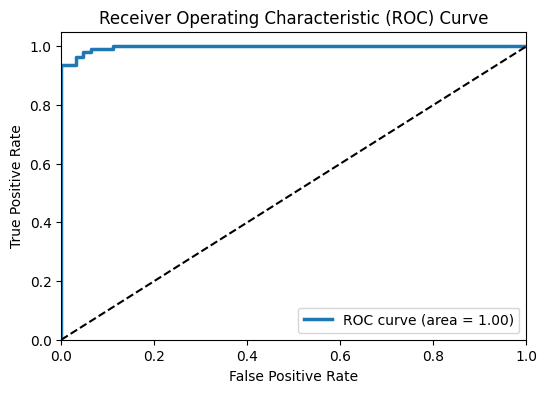

In [56]:
def get_class_labels(clf, label_encoder=None, class_names=None):
    """
    Retrieves class labels from a classifier, label encoder, or directly from
    provided class names.

    Args:
        clf: A trained classifier object.
        label_encoder: Optional. A fitted LabelEncoder object.
        class_names: Optional. A list of class name strings.

    Returns:
        list: A list of class labels.

    Raises:
        ValueError: If class labels cannot be determined from any of the inputs.
    """
    # Check if the classifier object has class labels defined
    if hasattr(clf, "classes_"):
        # If yes, get class labels from the classifier
        class_labels = clf.classes_
    # Else if a label encoder is provided
    elif label_encoder:
        # If yes, get class labels from the label encoder
        class_labels = label_encoder.classes_
    # Else if class names are directly provided
    elif class_names:
        # If yes, use the provided class names
        class_labels = class_names
    # Else if no class labels can be derived
    else:
        # Raise a ValueError indicating inability to determine prediction classes
        raise ValueError(
            "Unable to derive prediction classes, please specify class_names!"
        )
    return class_labels


def get_prediction_scores(clf, features):
    """
    Gets prediction scores (probabilities or decision function values) from a
    classifier.

    Args:
        clf: A trained classifier object.
        features: Feature matrix to get predictions for.

    Returns:
        An array of prediction scores or probabilities.

    Raises:
        AttributeError: If the classifier doesn't have predict_proba or decision_function methods.
    """
    # Check if the classifier has a predict_proba method (for probability estimates)
    if hasattr(clf, "predict_proba"):
        # Get probability predictions from the classifier
        return clf.predict_proba(features)
    # Else if the classifier has a decision_function method (for decision values)
    elif hasattr(clf, "decision_function"):
        # Get decision function values from the classifier
        return clf.decision_function(features)
    # Else if the classifier has neither predict_proba nor decision_function
    else:
        # Raise an AttributeError indicating the estimator lacks probability or confidence scoring
        raise AttributeError(
            "Estimator doesn't have a probability or confidence scoring system!"
        )


def calculate_binary_roc_data(y_test, y_score):
    """
    Calculates ROC curve data for binary classification.

    Args:
        y_test: True binary labels.
        y_score: Target scores (probabilities or decision function outputs).

    Returns:
        tuple: A tuple containing (fpr, tpr, roc_auc) where:
            - fpr: array of false positive rates
            - tpr: array of true positive rates
            - roc_auc: area under the ROC curve
    """
    # Compute False Positive Rate, True Positive Rate, and thresholds for ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    
    # Compute Area Under the ROC Curve (ROC AUC)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


def plot_binary_roc_curve(fpr, tpr, roc_auc):
    """
    Plots the ROC curve for binary classification.

    Args:
        fpr: Array of false positive rates.
        tpr: Array of true positive rates.
        roc_auc: Area under the ROC curve.
    """
    # Create a new figure for plotting ROC curves
    plt.figure(figsize=(6, 4))

    # Plot the ROC curve for binary classification
    plt.plot(
        fpr,  # False Positive Rate (FPR) values for the ROC curve (x-axis)
        tpr,  # True Positive Rate (TPR) values for the ROC curve (y-axis)
        label="ROC curve (area = {0:0.2f})".format(roc_auc),  # Label for the ROC curve, including the AUC value formatted to 2 decimal places
        linewidth=2.5,  # Set the line width of the ROC curve to 2.5 for better visibility
    )


def calculate_multiclass_roc_data(y_test, y_score, n_classes):
    """
    Calculates ROC curve data for multi-class classification.

    Args:
        y_test: Binarized true labels.
        y_score: Target scores (probabilities or decision function outputs).
        n_classes: Number of classes.

    Returns:
        tuple: A tuple containing (fpr, tpr, roc_auc) where:
            - fpr: dictionary of false positive rates for each class, plus 'micro' and 'macro' averages
            - tpr: dictionary of true positive rates for each class, plus 'micro' and 'macro' averages
            - roc_auc: dictionary of ROC AUC values for each class, plus 'micro' and 'macro' averages
    """

    # Initialize dictionaries to store false positive rates, true positive
    # rates, and ROC AUC values for each class.
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Iterate through each class to compute ROC curve and AUC
    for i in range(n_classes):
        # Compute FPR, TPR, and thresholds for each class's ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        
        # Compute ROC AUC for each class
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve (considering all classes together)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    
    # Compute ROC AUC for micro-average ROC curve
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # Initialize an array to store all false positive rates for macro-average calculation
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Initialize an array to store interpolated true positive rates
    mean_tpr = np.zeros_like(all_fpr)
    
    # Interpolate ROC curves at each point for macro-average
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Average true positive rates to get macro-average TPR
    mean_tpr /= n_classes
    
    # Assign macro-average FPR and TPR to dictionaries
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    
    # Compute ROC AUC for macro-average ROC curve
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc


def plot_multiclass_roc_curves(fpr, tpr, roc_auc, class_labels):
    """
    Plots ROC curves for multi-class classification, including micro and macro averages.

    Args:
        fpr: Dictionary of false positive rates for each class, plus 'micro' and 'macro' averages.
        tpr: Dictionary of true positive rates for each class, plus 'micro' and 'macro' averages.
        roc_auc: Dictionary of ROC AUC values for each class, plus 'micro' and 'macro' averages.
        class_labels: List of class labels corresponding to the classes.
    """
    # Create a new figure for plotting ROC curves
    plt.figure(figsize=(6, 4))
    
    # Plot the micro-average ROC curve for multi-class classification
    plt.plot(
        fpr["micro"],  # Micro-average False Positive Rate (FPR) values (x-axis)
        tpr["micro"],  # Micro-average True Positive Rate (TPR) values (y-axis)
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),  # Label for the micro-average ROC curve, including the micro-average AUC value formatted to 2 decimal places
        linewidth=3,  # Set the line width of the ROC curve to 3 for better visibility
    )

    # Plot the macro-average ROC curve for multi-class classification
    plt.plot(
        fpr["macro"],  # Macro-average False Positive Rate (FPR) values (x-axis)
        tpr["macro"],  # Macro-average True Positive Rate (TPR) values (y-axis)
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),  # Label for the macro-average ROC curve, including the macro-average AUC value formatted to 2 decimal places
        linewidth=3,  # Set the line width of the ROC curve to 3 for better visibility
    )

    # Plot the ROC curve for each individual class in a multi-class classification problem
    for i, label in enumerate(class_labels):  # Iterate over each class using its index 'i' and label
        plt.plot(
            fpr[i],  # False Positive Rate (FPR) values for the i-th class (x-axis)
            tpr[i],  # True Positive Rate (TPR) values for the i-th class (y-axis)
            label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]),  # Label for the ROC curve of the i-th class, including the class label and AUC value formatted to 2 decimal places
            linewidth=2,  # Set the line width of the ROC curve to 2 for better visibility
            linestyle=":",  # Use a dotted line style to distinguish the ROC curve of each class
        )


def finalize_plot(plot_title="Receiver Operating Characteristic (ROC) Curve"):
    """
    Finalizes and displays the ROC curve plot with appropriate labels and formatting.
    """
    # Plot the diagonal line representing chance level performance
    plt.plot([0, 1], [0, 1], "k--")
    
    # Set x-axis limits from 0 to 1
    plt.xlim([0.0, 1.0])
    
    # Set y-axis limits from 0 to 1.05 for better visualization
    plt.ylim([0.0, 1.05])
    
    # Set x-axis label
    plt.xlabel("False Positive Rate")
    
    # Set y-axis label
    plt.ylabel("True Positive Rate")
    
    # Set plot title
    plt.title(plot_title)
    
    # Display legend to identify each ROC curve
    plt.legend(loc="lower right")
    
    # Show the plot
    plt.show()


def plot_model_roc_curve(
    clf,
    features,
    true_labels,
    label_encoder=None,
    class_names=None,
    plot_title="Receiver Operating Characteristic (ROC) Curve",
):
    """
    Plots ROC curve(s) for a classifier's predictions.

    Args:
        clf: A trained classifier object.
        features: Feature matrix to make predictions on.
        true_labels: True labels corresponding to the features.
        label_encoder: Optional. A fitted LabelEncoder object.
        class_names: Optional. A list of class name strings.

    Raises:
        ValueError: If the number of classes is less than 2.
    """
    # Get class labels for the classifier
    class_labels = get_class_labels(clf, label_encoder, class_names)

    # Get the number of classes from the class labels
    n_classes = len(class_labels)

    # Binarize the true labels for ROC curve calculation, handling multi-class scenarios
    y_test = label_binarize(true_labels, classes=class_labels)

    # Check if it's a binary classification problem (2 classes)
    if n_classes == 2:
        # Get probability predictions from the classifier
        # - clf: The trained classifier model
        # - features: The input features (e.g., X_test) for which predictions are to be made
        prob = get_prediction_scores(clf, features)  # Obtain probability scores for each class
        
        # Extract probabilities for the positive class (assuming binary classification)
        # - In binary classification, the positive class is typically represented by the last column of the probability array
        y_score = prob[:, prob.shape[1] - 1]  # Select the probabilities for the positive class
        
        # Compute Area Under the ROC Curve (ROC AUC) for binary classification
        # - y_test: The true labels (ground truth) for the test data
        # - y_score: The predicted probabilities for the positive class
        fpr, tpr, roc_auc = calculate_binary_roc_data(y_test, y_score)  # Compute FPR, TPR, and AUC
        
        # Plot the ROC curve for binary classification
        # - fpr: False Positive Rate (FPR) values for the ROC curve (x-axis)
        # - tpr: True Positive Rate (TPR) values for the ROC curve (y-axis)
        # - roc_auc: Area Under the Curve (AUC) value for the ROC curve
        plot_binary_roc_curve(fpr, tpr, roc_auc)  # Generate and display the ROC curve

    # Else if it's a multi-class classification problem (more than 2 classes)
    elif n_classes > 2:
        # Get probability predictions from the classifier
        # - clf: The trained classifier model
        # - features: The input features (X_test) for which predictions are to be made
        y_score = get_prediction_scores(clf, features)  # Obtain probability scores for each class

        # Calculate ROC curve data for multi-class classification
        # - y_test: The true labels (ground truth) for the test data
        # - y_score: The predicted probability scores for each class
        # - n_classes: The number of unique classes in the dataset
        fpr, tpr, roc_auc = calculate_multiclass_roc_data(y_test, y_score, n_classes)  # Compute FPR, TPR, and AUC for each class
        
        # Plot the ROC curves for multi-class classification
        # - fpr: Dictionary containing False Positive Rate (FPR) values for each class and averages
        # - tpr: Dictionary containing True Positive Rate (TPR) values for each class and averages
        # - roc_auc: Dictionary containing Area Under the Curve (AUC) values for each class and averages
        # - class_labels: List of class names or identifiers for labeling the curves
        plot_multiclass_roc_curves(fpr, tpr, roc_auc, class_labels)  # Generate and display the ROC curves

    # Else if the number of classes is less than 2 (invalid case)
    else:
        # Raise a ValueError for insufficient number of classes for ROC curve plotting
        raise ValueError("Number of classes should be atleast 2 or more")

    # Call finalize_plit()
    finalize_plot(plot_title)


# Example function call to plot ROC curve for a logistic regression classifier 'logistic'
plot_model_roc_curve(clf=logistic, features=X_test, true_labels=y_test)

In an ideal scenario, the best prediction model would produce a point at the top-left corner (0, 1) of the ROC curve, indicating perfect classification with 100% sensitivity (true positive rate) and 100% specificity (1 - false positive rate). A diagonal line in the ROC plot represents a classifier that performs no better than random guessing. If your ROC curve lies in the top half of the graph, it indicates a decent classifier that performs better than random. The plot above demonstrates a near-perfect ROC curve, which is rare in practice.

However, real-world data is often not so well-behaved. To simulate this, we can create a function that randomly "flips" a certain proportion of the true labels (y values). The more labels we flip, the worse the classifier's performance becomes, as the "true" labels increasingly deviate from the ones used during training. This degradation in performance will be reflected in the ROC curves, which will gradually move closer to the diagonal line, indicating poorer classification. Let’s explore this in detail:

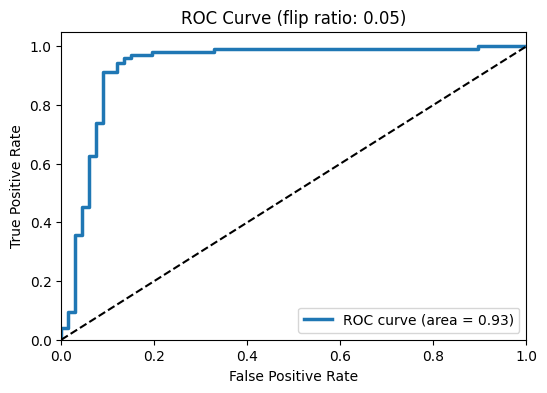

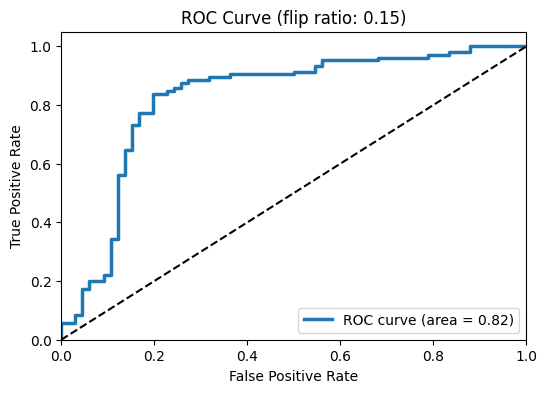

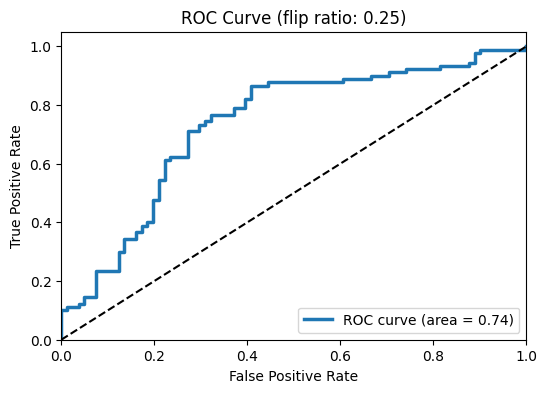

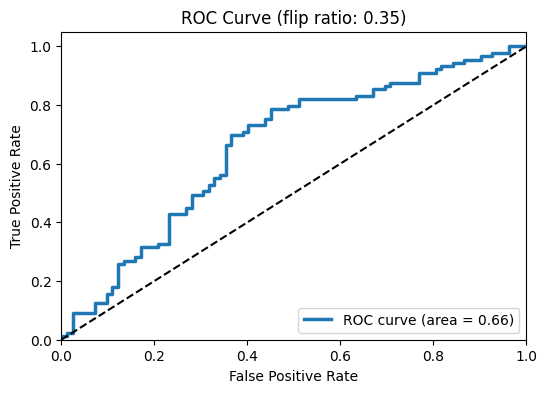

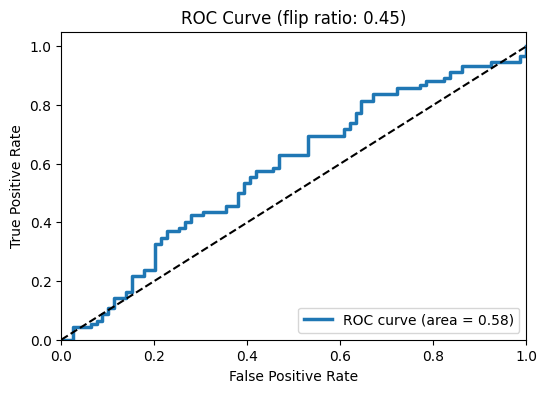

In [57]:
def flip_labels(y, flip_ratio):
    """
    Randomly flip a proportion of labels in a binary array

    Parameters:
    y (np.ndarray): Binary array (with values 0 and 1)
    flip_ratio (float): Ratio of labels to flip (0-1)

    Returns:
    np.ndarray: Array with flipped labels
    """
    # Create a copy to avoid modifying the original
    y_flipped = y.copy()

    # Create a random mask for elements to flip
    # - flip_ratio: The proportion of labels to flip (e.g., 0.1 for 10%)
    # - len(y): The total number of labels in the dataset
    n_to_flip = int(len(y) * flip_ratio)  # Calculate the number of labels to flip based on the flip ratio
    
    # Randomly select indices of labels to flip
    # - len(y): The total number of labels
    # - size=n_to_flip: The number of indices to select
    # - replace=False: Ensure that the same index is not selected more than once
    flip_indices = np.random.choice(len(y), size=n_to_flip, replace=False)  # Generate random indices for flipping

    # Flip the selected labels (0 -> 1, 1 -> 0)
    y_flipped[flip_indices] = 1 - y_flipped[flip_indices]

    return y_flipped


# Iterate over a list of flip ratios to simulate increasing levels of label noise
for flip_ratio in [0.05, 0.15, 0.25, 0.35, 0.45]:
    # Plot the ROC curve for the logistic regression model with flipped labels
    plot_model_roc_curve(
        clf=logistic,  # The trained logistic regression model
        features=X_test,  # The test feature data (input to the model)
        true_labels=flip_labels(y_test, flip_ratio),  # The true labels with a specified proportion flipped
        plot_title=f"ROC Curve (flip ratio: {flip_ratio})",  # Title for the plot, showing the flip ratio
    )

The plots above show the Receiver Operating Characteristic (ROC) curves for different levels of label noise (flip ratio). ROC curves are used to evaluate the performance of classification models by plotting the true positive rate (sensitivity) against the false positive rate. A higher area under the curve (AUC) indicates better model performance.

In the first plot, with a flip ratio of 0.05, the ROC curve shows an AUC of 0.94, indicating a strong classification ability. As the flip ratio increases to 0.15 in the second plot, the AUC decreases to 0.84, suggesting that label noise is beginning to degrade model performance but the classifier still performs well.

The third plot, with a flip ratio of 0.25, exhibits an AUC of 0.76, showing a more significant decline in predictive accuracy. The fourth plot, with a flip ratio of 0.35, sees the AUC drop further to 0.64, indicating that the model is struggling to differentiate between classes effectively.

Finally, in the last plot with a flip ratio of 0.45, the AUC reaches 0.59, approaching random classification performance (AUC = 0.5). This suggests that the introduced noise has severely impacted the classifier's ability to learn meaningful patterns.

Overall, the plots illustrate how increasing label noise negatively affects model performance, demonstrating the importance of clean and accurate labels in machine learning tasks.

## Clustering Model Evaluation Metrics

The absence of a validated ground truth, or true labels, in the dataset poses a significant challenge when evaluating clustering algorithms or unsupervised models in general. Unlike supervised learning, where models are trained and evaluated using labeled data, unsupervised learning operates without any predefined labels. This lack of true labels makes it inherently difficult to assess the quality or accuracy of the clustering results.

In supervised learning, metrics such as accuracy, precision, recall, and F1-score rely on comparing predicted labels to true labels. However, in unsupervised learning, these metrics are not applicable because there are no true labels to serve as a reference. Instead, evaluation often relies on intrinsic metrics (e.g., silhouette score, Davies-Bouldin index) that measure the internal structure of the clusters, such as cohesion (how closely related points are within a cluster) and separation (how distinct clusters are from one another). While these metrics provide some insight, they do not guarantee that the clusters align with any meaningful or interpretable grouping in the data.

Moreover, without true labels, it is challenging to determine whether the clustering results are meaningful or simply an artifact of the algorithm's assumptions. For example, a clustering algorithm might produce well-separated clusters, but these clusters may not correspond to any real-world categories or patterns. This limitation underscores the importance of domain knowledge and qualitative analysis when interpreting clustering results. Domain experts can often provide valuable insights into whether the clusters align with expected or meaningful groupings.

In some cases, semi-supervised learning or external validation can be used to partially address this issue. Semi-supervised learning incorporates a small amount of labeled data to guide the clustering process, while external validation involves comparing clustering results to an external source of truth, if available. However, these approaches are not always feasible, especially in fully unsupervised scenarios where labeled data is entirely absent.

The lack of validated ground truth makes evaluating unsupervised models inherently challenging. While intrinsic metrics and domain expertise can provide some guidance, the absence of true labels remains a fundamental limitation in assessing the effectiveness and interpretability of clustering algorithms.


### Build two clustering models on the breast cancer dataset

We will leverage the breast cancer
dataset available in the variables X for the data and y for the observation labels. We will also use the K-means
algorithm to fit two models on this data—one with two clusters and the second one with five clusters—and
then evaluate their performance.


In [58]:
# Initialize KMeans clustering with 2 clusters and a fixed random state for reproducibility, then fit it to the data X.
km2 = KMeans(n_clusters=2, random_state=42).fit(X)

# Get the cluster labels assigned by the KMeans model (km2) after fitting.
km2_labels = km2.labels_

# Initialize KMeans clustering with 5 clusters and a fixed random state for reproducibility, then fit it to the data X.
km5 = KMeans(n_clusters=5, random_state=42).fit(X)

# Get the cluster labels assigned by the KMeans model (km5) after fitting.
km5_labels = km5.labels_

### External validation

External validation refers to the process of evaluating a clustering model when ground truth labels are available. Unlike unsupervised learning, where true labels are absent, the presence of external labels simplifies the evaluation process significantly. With labeled data, clustering models can be assessed in a manner similar to supervised classification models, using metrics that compare the predicted clusters to the true labels.

In this scenario, three popular metrics are commonly used to evaluate clustering performance:

**Homogeneity**:
- A clustering result satisfies homogeneity if each cluster contains only data points that belong to a single class according to the true labels.
- In other words, clusters are pure and do not mix data points from different classes.
- A homogeneity score of 1 indicates perfect clustering, where all clusters are homogeneous.

**Completeness**:
- A clustering result satisfies completeness if all data points belonging to a specific true class are assigned to the same cluster.
- This ensures that no class is split across multiple clusters.
- A completeness score of 1 indicates that all data points of each class are grouped together.

**V-measure**:
- The V-measure is the harmonic mean of the homogeneity and completeness scores.
- It provides a single metric that balances the trade-off between homogeneity and completeness.
- Like the other metrics, the V-measure ranges between 0 and 1, with higher values indicating better clustering performance.

These metrics are bounded between 0 and 1, where values closer to 1 indicate better alignment between the clustering results and the true labels. Higher scores are generally desirable, as they reflect more accurate and meaningful clustering.

In [59]:
# Calculates the Homogeneity, Completeness, and V-measure metrics for KMeans clustering with 2 clusters and rounds the results to 3 decimal places.
km2_hcv = np.round(metrics.homogeneity_completeness_v_measure(y, km2_labels), 3)

# Calculates the Homogeneity, Completeness, and V-measure metrics for KMeans clustering with 5 clusters and rounds the results to 3 decimal places.
km5_hcv = np.round(metrics.homogeneity_completeness_v_measure(y, km5_labels), 3)

# Prints the Homogeneity, Completeness, and V-measure metrics for the KMeans clustering with 2 clusters.
print("Homogeneity, Completeness, V-measure metrics for num clusters=2: ", km2_hcv)

# Prints the Homogeneity, Completeness, and V-measure metrics for the KMeans clustering with 5 clusters.
print("Homogeneity, Completeness, V-measure metrics for num clusters=5: ", km5_hcv)

Homogeneity, Completeness, V-measure metrics for num clusters=2:  [0.422 0.517 0.465]
Homogeneity, Completeness, V-measure metrics for num clusters=5:  [0.602 0.297 0.398]


We can see that the V-measure for the first model with two clusters is better than the one with five
clusters and the reason is because of higher completeness score.


### Internal validation

Internal validation refers to the process of evaluating a clustering model using intrinsic metrics that capture the expected characteristics of a good clustering result. Unlike external validation, which relies on ground truth labels, internal validation assesses the quality of clustering based solely on the structure and distribution of the data itself. A well-performing clustering model should exhibit two key traits:

**Compact Groups**:
- Data points within the same cluster should be close to each other, indicating high cohesion.
- This means that the intra-cluster distances (distances between points within the same cluster) should be as small as possible.

**Well-Separated Groups**:
- Clusters should be distinct and far apart from one another, indicating high separation.
- This means that the inter-cluster distances (distances between points in different clusters) should be as large as possible.

These two traits form the foundation of internal validation metrics, which aim to quantify how well a clustering model achieves these objectives. Some commonly used internal validation metrics include:

- **Silhouette Score**: Measures how similar a data point is to its own cluster compared to other clusters. Higher values indicate better-defined clusters.

- **Davies-Bouldin Index**: Evaluates the ratio of intra-cluster distances to inter-cluster distances. Lower values indicate better clustering.

- **Calinski-Harabasz Index**: Assesses the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better clustering.

By using these metrics, you can evaluate the quality of clustering results without the need for ground truth labels, making internal validation particularly useful in fully unsupervised scenarios.


#### Silhouette Coefficient

The **Silhouette Coefficient** is a metric designed to evaluate the quality of clustering by combining two key aspects of a good clustering model: **compactness** (how close data points are within the same cluster) and **separation** (how distinct clusters are from one another). It provides a measure of how well each data point fits into its assigned cluster compared to other clusters.

For each data point, the Silhouette Coefficient is calculated as a combination of:
1. **Similarity to its own cluster**: The average distance between the data point and all other points in the same cluster.
2. **Dissimilarity to other clusters**: The average distance between the data point and all points in the nearest neighboring cluster.

The Silhouette Coefficient for a single data point is defined as:
$$
s = \frac{(b - a)}{\max(a, b)}
$$
where:
- $a$ is the average intra-cluster distance (compactness).
- $b$ is the average nearest-cluster distance (separation).

The overall Silhouette Coefficient for the dataset is the average of the Silhouette Coefficients for all data points.

- The Silhouette Coefficient ranges from **-1 to +1**:
  - **+1**: Indicates excellent clustering, with dense and well-separated clusters.
  - **0**: Suggests overlapping clusters, where the clustering model does not clearly distinguish between groups.
  - **-1**: Implies incorrect clustering, where data points may be assigned to the wrong clusters.

A higher Silhouette Coefficient generally indicates that the clustering model produces **dense and well-separated clusters**, making it easier to distinguish between different groups. Conversely, lower scores suggest that clusters may overlap or are not well-defined.

In [60]:
# Calculates the silhouette score for k-means clustering with 2 clusters using the 'euclidean' distance metric.
km2_silc = metrics.silhouette_score(X, km2_labels, metric="euclidean")

# Calculates the silhouette score for k-means clustering with 5 clusters using the 'euclidean' distance metric.
km5_silc = metrics.silhouette_score(X, km5_labels, metric="euclidean")

# Prints the silhouette coefficient calculated for the k-means model with 2 clusters.
print("Silhouette Coefficient for num clusters=2: ", km2_silc)

# Prints the silhouette coefficient calculated for the k-means model with 5 clusters.
print("Silhouette Coefficient for num clusters=5: ", km5_silc)

Silhouette Coefficient for num clusters=2:  0.6972646156059464
Silhouette Coefficient for num clusters=5:  0.5127536688145046


We can observe that from the metric results it seems like we have better
cluster quality with two clusters as compared to five clusters.


#### Davies-Bouldin Index

The **Davies-Bouldin Index** is a metric used to evaluate the quality of clustering by measuring the trade-off between **compactness** (how tightly grouped data points are within a cluster) and **separation** (how distinct clusters are from one another). Unlike the Silhouette Coefficient, which focuses on individual data points, the Davies-Bouldin Index evaluates the overall clustering structure by comparing the average distances within clusters to the distances between clusters.

The Davies-Bouldin Index is calculated as the average similarity ratio of each cluster to its most similar cluster. The similarity ratio for a cluster $i$ is defined as:
$$
R_i = \max_{j \neq i} \left( \frac{S_i + S_j}{d(C_i, C_j)} \right)
$$
where:
- $S_i$ is the average distance between each point in cluster $i$ and the centroid of cluster $i$ (intra-cluster distance).
- $S_j$ is the average distance between each point in cluster $j$ and the centroid of cluster $j$ (intra-cluster distance).
- $d(C_i, C_j)$ is the distance between the centroids of clusters $i$ and $j$ (inter-cluster distance).

The overall Davies-Bouldin Index is the average of $R_i$ for all clusters:
$$
DB = \frac{1}{n} \sum_{i=1}^{n} R_i
$$
where $n$ is the number of clusters.

- The Davies-Bouldin Index ranges from **0 to infinity**, but lower values are better.
  - **0**: Indicates perfect clustering, with compact and well-separated clusters.
  - **Higher values**: Suggest overlapping or poorly separated clusters.
- A lower Davies-Bouldin Index generally indicates that the clustering model produces **dense and well-separated clusters**, while higher values indicate that clusters may overlap or are not well-defined.

In [61]:
# Calculate the Davies-Bouldin Index for k-means clustering with 2 clusters.
km2_dbi = metrics.davies_bouldin_score(X, km2_labels)

# Calculate the Davies-Bouldin Index for k-means clustering with 5 clusters.
km5_dbi = metrics.davies_bouldin_score(X, km5_labels)

# Print the Davies-Bouldin Index for the clustering with 2 clusters.
print("Davies-Bouldin Index for num clusters=2: ", km2_dbi)

# Print the Davies-Bouldin Index for the clustering with 5 clusters.
print("Davies-Bouldin Index for num clusters=5: ", km5_dbi)

Davies-Bouldin Index for num clusters=2:  0.504403568541099
Davies-Bouldin Index for num clusters=5:  0.6187781643742062


We can observe that from the metric results it seems like we have better
cluster quality with two clusters as compared to five clusters.

#### Calinski-Harabasz Index

The **Calinski-Harabasz Index** (also known as the **Variance Ratio Criterion**) is a metric used to evaluate the quality of clustering by measuring the ratio of **between-cluster dispersion** to **within-cluster dispersion**. This index quantifies how well-separated and compact the clusters are, making it a useful tool for assessing the overall effectiveness of a clustering model.

The Calinski-Harabasz Index is calculated as:
$$
CH = \frac{\text{Between-Cluster Dispersion} / (k - 1)}{\text{Within-Cluster Dispersion} / (n - k)}
$$
where:
- **Between-Cluster Dispersion**: The sum of squared distances between the centroids of each cluster and the global centroid of the dataset.
- **Within-Cluster Dispersion**: The sum of squared distances between each data point and the centroid of its assigned cluster.
- $k$: The number of clusters.
- $n$: The total number of data points.

- The Calinski-Harabasz Index ranges from **0 to infinity**, but higher values are better.
  - **Higher values**: Indicate well-separated and compact clusters.
  - **Lower values**: Suggest overlapping or poorly defined clusters.
- A higher Calinski-Harabasz Index generally indicates that the clustering model produces **distinct and tightly grouped clusters**, while lower values indicate that clusters may overlap or are not well-defined.

In [62]:
# Calculate the Calinski-Harabasz Index for k-means clustering with 2 clusters.
km2_chi = metrics.calinski_harabasz_score(X, km2_labels)

# Calculate the Calinski-Harabasz Index for k-means clustering with 5 clusters.
km5_chi = metrics.calinski_harabasz_score(X, km5_labels)

# Print the Calinski-Harabasz Index for the clustering with 2 clusters.
print("Calinski-Harabaz Index for num clusters=2: ", km2_chi)

# Print the Calinski-Harabasz Index for the clustering with 5 clusters.
print("Calinski-Harabaz Index for num clusters=5: ", km5_chi)

Calinski-Harabaz Index for num clusters=2:  1300.2082268895424
Calinski-Harabaz Index for num clusters=5:  1614.7693837192949


We can see that both the scores are pretty high with the results for five clusters being even higher. This
goes to show that just relying on metric number alone is not sufficient and you must try multiple evaluation
methods coupled with feedback from data scientists as well as domain experts.


## Conclusion

Through this tutorial, we've learned essential skills in model building and evaluation, including:

- How to properly evaluate classification models using multiple metrics
- Understanding the differences between internal and external clustering validation
- Practical application of evaluation metrics on real biomedical data
- Interpreting model performance through various visualization techniques

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.
